In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Function to reduce memory usage of the dataset**

In [ ]:

def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df



Putting dataset of 5min for 1 year

In [ ]:
data = pd.read_excel('https://github.com/cruveilc/Occupancy-Forecasting/blob/main/output.xlsx?raw=true',
sheet_name=0,
header=0,
index_col=[0],
keep_default_na=True
).pipe(reduce_mem_usage, verbose=True)

#data = data[data.index.dayofweek < 5]
#data = data.between_time('06:00','23:00')
data=data[['label']]
time = data.index

Mem. usage decreased to  3.24 Mb (48.4% reduction)


In [ ]:
data

,label
time,
2015-01-06 15:00:00,1.128000
2015-01-06 15:05:00,0.622000
2015-01-06 15:10:00,0.634000
2015-01-06 15:15:00,0.285733
2015-01-06 15:20:00,0.094000
...,...
2015-12-30 00:05:00,0.010000
2015-12-30 00:10:00,0.010000
2015-12-30 00:15:00,0.010000


We are resampling the dataset to 1hour

In [ ]:
df=data
df['NewDateTime'] = pd.to_datetime(df.index)
df.index = df['NewDateTime']
df_p = df.resample('H').mean()
df_p[df_p.isnull().any(axis=1)]=0.1
df_p=df_p.clip(lower=0.001)
df_p

,label
NewDateTime,
2015-01-06 15:00:00,0.272478
2015-01-06 16:00:00,1.830740
2015-01-06 17:00:00,1.842989
2015-01-06 18:00:00,2.603144
2015-01-06 19:00:00,2.724946
...,...
2015-12-29 20:00:00,0.001000
2015-12-29 21:00:00,0.011667
2015-12-29 22:00:00,0.009167


In [ ]:
time = df_p.index

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('label%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('label%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('label%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = time
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
     
    return agg

We tested preprocessing functions but the accuracy wasn't improving that much so we decided to keep the values of occupancy as they were so we could have direct visulisation without having to retransform.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
data2=df_p[['label']]

#print(data.iloc[:,0])
#labelEncoder = LabelEncoder()
#data.iloc[:,0] = labelEncoder.fit_transform(data.iloc[:,0])
values = data2.values
print(values.shape)
values = values.astype('float32')

(8578, 1)


In [ ]:

n_in = 24*2
n_out=24
#scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
#scaled = scaler.fit_transform(values)
reframed = series_to_supervised(values,n_in,n_out)

**Importing the calendar and creating a calendar dataframe**

In [ ]:
!pip install icalendar

In [ ]:
from icalendar import Calendar, Event
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime

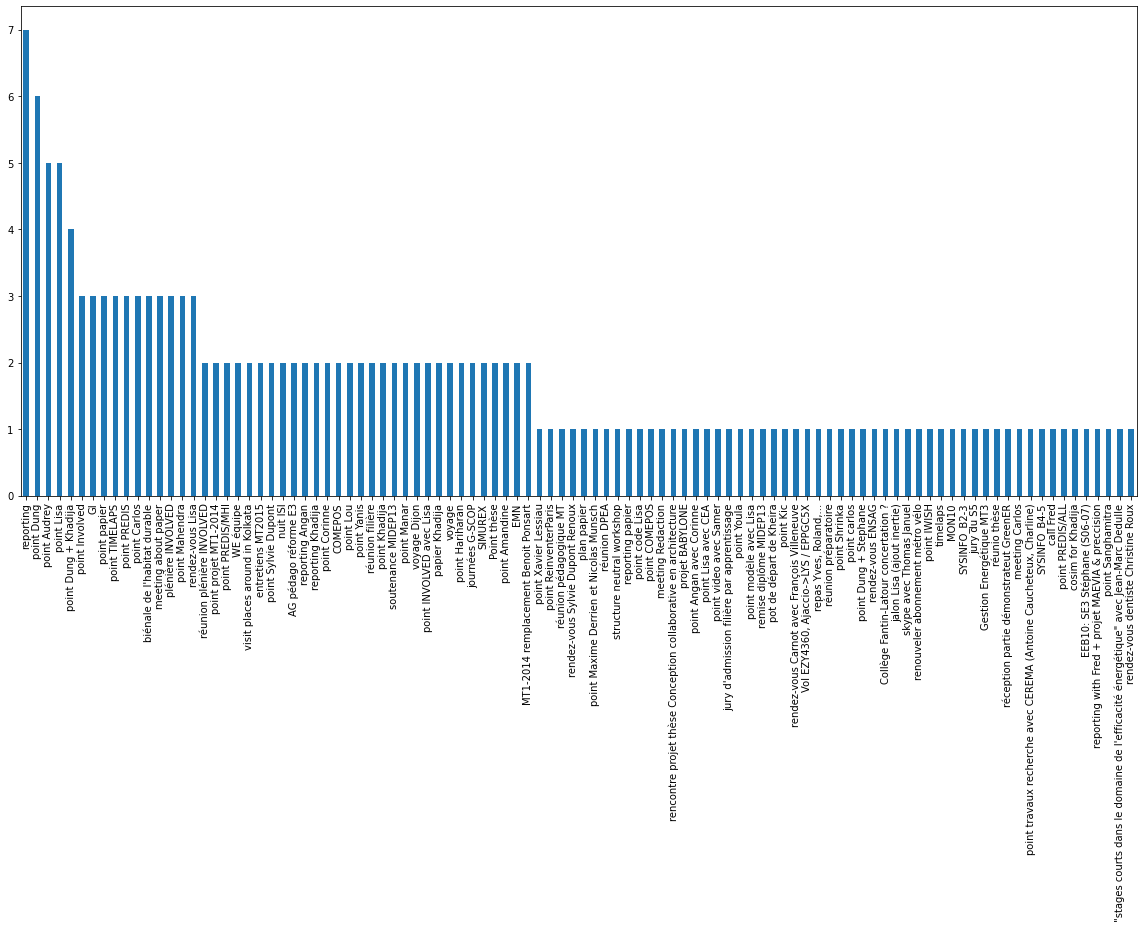

                                         evenement  ... label
debut                                               ...      
2015-01-05 09:15:00                          POO13  ...     1
2015-01-05 15:00:00        point Murielle sur DPEA  ...     2
2015-01-06 13:00:00                réunion mission  ...     1
2015-01-07 07:30:00              Rdv projet Ayesha  ...     1
2015-01-07 08:30:00  appeler amandine pour facture  ...     1

[5 rows x 4 columns]
Empty DataFrame
Columns: [evenement, debut, fin, label]
Index: []
fin test


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

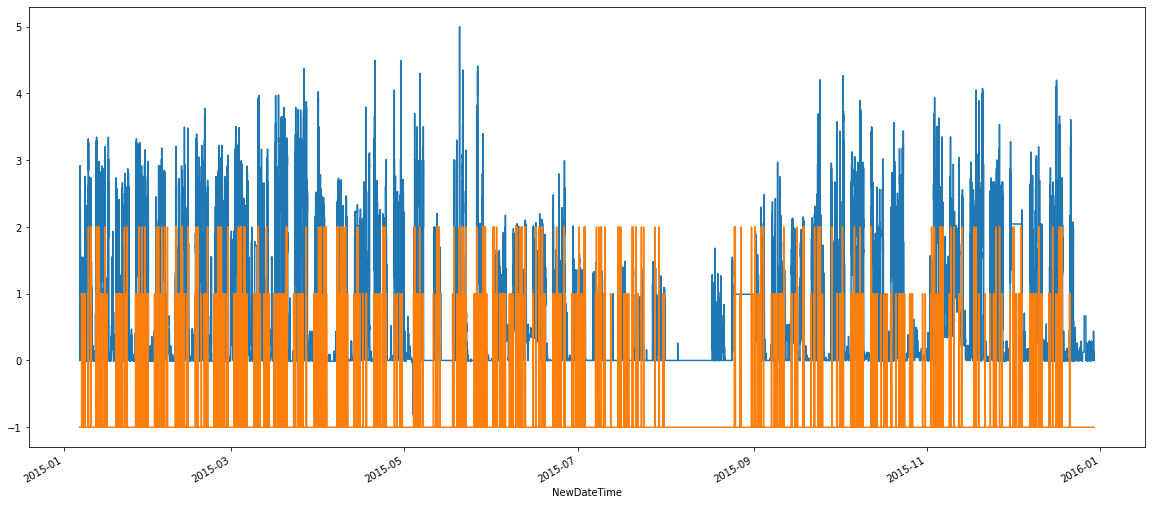

In [ ]:
evenement = []
debut = []
fin =[]


g = open('/content/stephane_stephane.ploix@gmail.com.ics','rb')
gcal = Calendar.from_ical(g.read().decode())
for component in gcal.walk():
    if component.name == "VEVENT":

        evenement.append(str((component.get('summary'))))
        if len(str(component.get('dtstart').dt)) >12:
            debut.append(datetime.strptime(str(component.get('dtstart').dt)[:-6],'%Y-%m-%d %H:%M:%S'))
        else:
            debut.append(datetime.strptime(str(component.get('dtstart').dt), '%Y-%m-%d'))
        if component.get('dtend') is not None:
            fin.append(component.get('dtend').dt)
        else:
            fin.append("Nan")

g.close()

calendrier = pd.DataFrame({'evenement': evenement,'debut':debut,'fin':fin})
calendrier['debut'] =pd.to_datetime(calendrier.debut)
calendrier.sort_values(['debut'], inplace=True)
calendrier = calendrier.set_index(calendrier['debut'])
calendrier = calendrier['2015-01-04':'2015-12-31']


plt.figure(figsize=(20,9))
calendrier.evenement.value_counts()[0:100].plot.bar()
plt.show()

label = []
for k in calendrier.index:
    if "point" in calendrier['evenement'].loc[str(k)]:
        label.append(2)
    else:
        label.append(1)

calendrier['label']=label
print(calendrier.head())



cal = []
nom = []
for k in data['label']:
    cal.append(-1)
    nom.append("None")

data['calendrier'] = cal
data['nom']=nom

calendrier.drop_duplicates(subset ="debut",
                     keep = False, inplace = True)
print(calendrier[calendrier.index.duplicated()])
print("fin test")

for k in calendrier.index:
    if k in data.index:
        data['calendrier'].loc[str(k)] = calendrier['label'].loc[str(k)]
        data['nom'].loc[str(k)] = calendrier['evenement'].loc[str(k)]

plt.figure(figsize=(20,9))
data['label'].plot()
data['calendrier'].plot()
plt.show()

In [ ]:
reframed.insert(0,'hour',reframed.index.hour)
reframed.insert(0,'dayofweek',reframed.index.dayofweek)
reframed.insert(0,'dayofmonth',reframed.index.day)
reframed.insert(0,'year',reframed.index.year)


**Creating future calendar feature**

In [ ]:
def calendar_feature(df):
  k = range(1,n_out)
  agg_list = [
        [['time'], 'calendrier',k,

    ]]
    
  for i, item in enumerate(agg_list):
        print(i)
        
        # unpack the parameters
        groupby_cols, target_col, lags = item
        groupby_col_str = "_".join(groupby_cols)
        
        for lag in lags:
                col_name = '_'+target_col+'_per_'+groupby_col_str+'_r''-_lag_'+str(lag)
                #df[col_name] = df[target_col].apply(lambda x: x.rolling(window=rolling_window).agg(agg_function).shift(lag))
                df[col_name] = df[target_col].shift(-lag)
    ## price related features
    #df['sell_price_norm'] = df['sell_price'] / df['max_sell_price_per_store_id_item_id_r365_lag_1']
    #df['sell_price_momentum'] = df['sell_price'] / df['mean_sell_price_per_store_id_item_id_r7_lag_1']

  return df

In [ ]:
data3 = calendar_feature(data)
#data2 = calendar_feature(data2)

0


In [ ]:
data3=data3.drop(['label','nom'],axis=1)


**Creating the final dataset including all the features using the merge function**

In [ ]:
reframed = data3[reframed.index[0]:reframed.index[-1]].merge(reframed,left_index=True,right_index=True)

In [ ]:
reframed1=reframed

In [ ]:
reframed.columns

Index(['NewDateTime', 'calendrier', '_calendrier_per_time_r-_lag_1',
       '_calendrier_per_time_r-_lag_2', '_calendrier_per_time_r-_lag_3',
       '_calendrier_per_time_r-_lag_4', '_calendrier_per_time_r-_lag_5',
       '_calendrier_per_time_r-_lag_6', '_calendrier_per_time_r-_lag_7',
       '_calendrier_per_time_r-_lag_8',
       ...
       'label1(t+14)', 'label1(t+15)', 'label1(t+16)', 'label1(t+17)',
       'label1(t+18)', 'label1(t+19)', 'label1(t+20)', 'label1(t+21)',
       'label1(t+22)', 'label1(t+23)'],
      dtype='object', length=101)

In [ ]:
reframed1=reframed1.drop(columns="NewDateTime")

In [ ]:
reframed1

,calendrier,_calendrier_per_time_r-_lag_1,_calendrier_per_time_r-_lag_2,_calendrier_per_time_r-_lag_3,_calendrier_per_time_r-_lag_4,_calendrier_per_time_r-_lag_5,_calendrier_per_time_r-_lag_6,_calendrier_per_time_r-_lag_7,_calendrier_per_time_r-_lag_8,_calendrier_per_time_r-_lag_9,_calendrier_per_time_r-_lag_10,_calendrier_per_time_r-_lag_11,_calendrier_per_time_r-_lag_12,_calendrier_per_time_r-_lag_13,_calendrier_per_time_r-_lag_14,_calendrier_per_time_r-_lag_15,_calendrier_per_time_r-_lag_16,_calendrier_per_time_r-_lag_17,_calendrier_per_time_r-_lag_18,_calendrier_per_time_r-_lag_19,_calendrier_per_time_r-_lag_20,_calendrier_per_time_r-_lag_21,_calendrier_per_time_r-_lag_22,_calendrier_per_time_r-_lag_23,year,dayofmonth,dayofweek,hour,label1(t-48),label1(t-47),label1(t-46),label1(t-45),label1(t-44),label1(t-43),label1(t-42),label1(t-41),label1(t-40),label1(t-39),label1(t-38),label1(t-37),...,label1(t-16),label1(t-15),label1(t-14),label1(t-13),label1(t-12),label1(t-11),label1(t-10),label1(t-9),label1(t-8),label1(t-7),label1(t-6),label1(t-5),label1(t-4),label1(t-3),label1(t-2),label1(t-1),label1(t),label1(t+1),label1(t+2),label1(t+3),label1(t+4),label1(t+5),label1(t+6),label1(t+7),label1(t+8),label1(t+9),label1(t+10),label1(t+11),label1(t+12),label1(t+13),label1(t+14),label1(t+15),label1(t+16),label1(t+17),label1(t+18),label1(t+19),label1(t+20),label1(t+21),label1(t+22),label1(t+23)
NewDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-08 15:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,8,3,15,0.272478,1.830740,1.842989,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,...,0.017333,0.001000,0.013000,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113,0.143371,0.192738,0.972180,0.898947,0.480267,0.057058,0.001000,0.001000,0.001000,0.002573,0.001000,0.004960,0.011467,0.001000,0.049667,0.001000,0.039333,0.002000,0.108347,0.867618,1.832707,2.173417,1.876653,1.848553
2015-01-08 16:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,8,3,16,1.830740,1.842989,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,...,0.001000,0.013000,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113,0.143371,0.192738,0.972180,0.898947,0.480267,0.057058,0.001000,0.001000,0.001000,0.002573,0.001000,0.004960,0.011467,0.001000,0.049667,0.001000,0.039333,0.002000,0.108347,0.867618,1.832707,2.173417,1.876653,1.848553,2.427903
2015-01-08 17:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,8,3,17,1.842989,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,0.361500,...,0.013000,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113,0.143371,0.192738,0.972180,0.898947,0.480267,0.057058,0.001000,0.001000,0.001000,0.002573,0.001000,0.004960,0.011467,0.001000,0.049667,0.001000,0.039333,0.002000,0.108347,0.867618,1.832707,2.173417,1.876653,1.848553,2.427903,3.142257
2015-01-08 18:00:00,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2015,8,3,18,2.603144,2.724946,2.350104,1.988613,1.305453,0.216000,0.650167,0.063172,0.251251,0.327167,0.361500,0.394167,...,0.006000,0.006000,0.013003,0.142519,0.015754,0.006000,0.015003,0.169917,1.437893,1.908919,2.424207,1.922431,0.502113,0.143371,0.192738,0.972180,0.898947,0.480267,0.057058,0.001000,0.001000,0.001000,0.002573,0.001000,0.004960,0.011467,0.001000,0.049667,0.001000,0.039333,0.002000,0.108347,0.867618,1.832707,2.173417,1.876653,1.848553,2.427903,3.142257,3.089073
2015-01-08 19

In [ ]:
n_col = len(reframed1.columns)

In [ ]:
values1 = reframed1.values
n_train = 6000
n_in=n_col-n_out
train = values1[:n_train]
test = values1[n_train:]
trainX,trainY = train[:,:-n_out],train[:,n_in:]
testX,testY = test[:,:-n_out],test[:,n_in:]

print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(6000, 76) (6000, 24) (2507, 76) (2507, 24)


In [ ]:
#trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
#testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])

In [ ]:
epochs = 5
batch = 10
lr = 0.001
model = Sequential()
model.add(LSTM(10,input_shape=(1,n_in),dropout=0.2))
model.add(Dense(24))
model.add(Dense(n_out))
model.compile(loss="mae",optimizer="adam",metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10)                3480      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                264       
_________________________________________________________________
dense_13 (Dense)             (None, 24)                600       
Total params: 4,344
Trainable params: 4,344
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = model.fit(trainX, trainY,epochs=epochs, verbose=2)


Epoch 1/5
188/188 - 2s - loss: 0.5078 - accuracy: 0.0355
Epoch 2/5
188/188 - 0s - loss: 0.4922 - accuracy: 0.0373
Epoch 3/5
188/188 - 0s - loss: 0.4878 - accuracy: 0.0755
Epoch 4/5
188/188 - 0s - loss: 0.4837 - accuracy: 0.0758
Epoch 5/5
188/188 - 0s - loss: 0.4803 - accuracy: 0.0460


In [ ]:
testX

array([[[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
          1.22831392e+00,  6.78446591e-01,  5.32542109e-01]],

       [[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
          6.78446591e-01,  5.32542109e-01,  3.26006889e-01]],

       [[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
          5.32542109e-01,  3.26006889e-01,  4.66985196e-01]],

       ...,

       [[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
          1.00000005e-03,  9.36515164e-03,  1.19856060e-01]],

       [[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
          9.36515164e-03,  1.19856060e-01,  1.23000003e-01]],

       [[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
          1.19856060e-01,  1.23000003e-01,  1.23000003e-01]]])

In [ ]:
yhat = model.predict(testX, verbose=0)

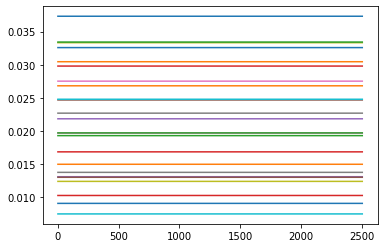

In [ ]:
plt.plot(yhat)

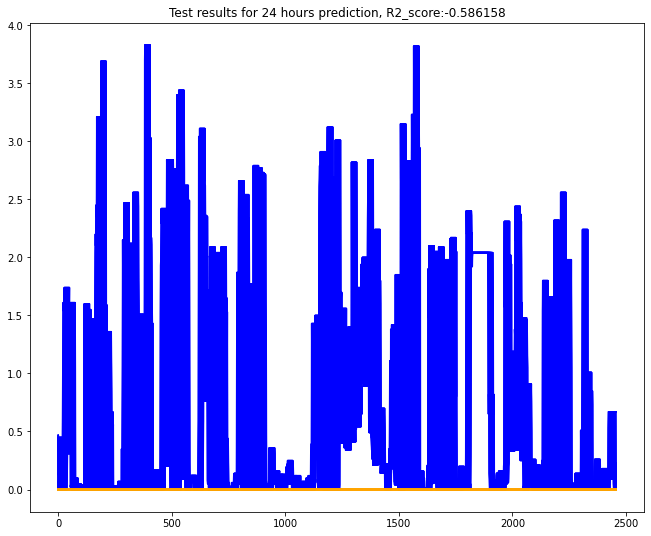

In [ ]:
from sklearn.metrics import r2_score
yhat[yhat <= 0.1] = 0
#ypred=ypred.reshape((testY.shape[0]))
plt.figure(figsize=(11,9))
plt.plot(testY[0:-50].round(2),label='Orginal',color = 'blue')
plt.plot(yhat[0:-50].round(2),label='Predicted',color = 'Orange')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY[0:-50],yhat[0:-50]))
plt.show()
#plt.legend(loc='best')

For some reasons that are still mysterious to us the model works really bad, according to what I read and tested on other datasets for other university projects LSTM doesn't sseem to show good results when you are introducing too few data.